In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset from CSV
df = pd.read_csv('/content/data_final.csv', parse_dates=['Date'], dayfirst=True)

# Sort the dataframe by date
df = df.sort_values('Date')

# Set 'Date' as the index
df.set_index('Date', inplace=True)

In [ ]:
# Prepare the data for training
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['price_coffee', 'price_oil']])

# Define the number of time steps to use for prediction
n_steps = 14

# Split the data into input sequences and corresponding target values
X = []
y = []
for i in range(n_steps, len(scaled_data)):
    X.append(scaled_data[i - n_steps:i])
    y.append(scaled_data[i, 0])  # Use price_coffee as the target variable

# Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
model = Sequential()
model.add(GRU(50, activation='relu', input_shape=(n_steps, 2)))
model.add(layers.Dropout(rate=0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1)




Epoch 1/200
97/97 [==============================] - 4s 15ms/step - loss: 0.0372
Epoch 2/200
97/97 [==============================] - 1s 10ms/step - loss: 0.0073
Epoch 3/200
97/97 [==============================] - 1s 9ms/step - loss: 0.0052
Epoch 4/200
97/97 [==============================] - 1s 10ms/step - loss: 0.0046
Epoch 5/200
97/97 [==============================] - 1s 9ms/step - loss: 0.0038
Epoch 6/200
97/97 [==============================] - 1s 9ms/step - loss: 0.0036
Epoch 7/200
97/97 [==============================] - 1s 9ms/step - loss: 0.0031
Epoch 8/200
97/97 [==============================] - 1s 9ms/step - loss: 0.0031
Epoch 9/200
97/97 [==============================] - 1s 9ms/step - loss: 0.0029
Epoch 10/200
97/97 [==============================] - 1s 9ms/step - loss: 0.0027
Epoch 11/200
97/97 [==============================] - 1s 9ms/step - loss: 0.0025
Epoch 12/200
97/97 [==============================] - 1s 9ms/step - loss: 0.0023
Epoch 13/200
97/97 [==============

25/25 [==============================] - 0s 3ms/step


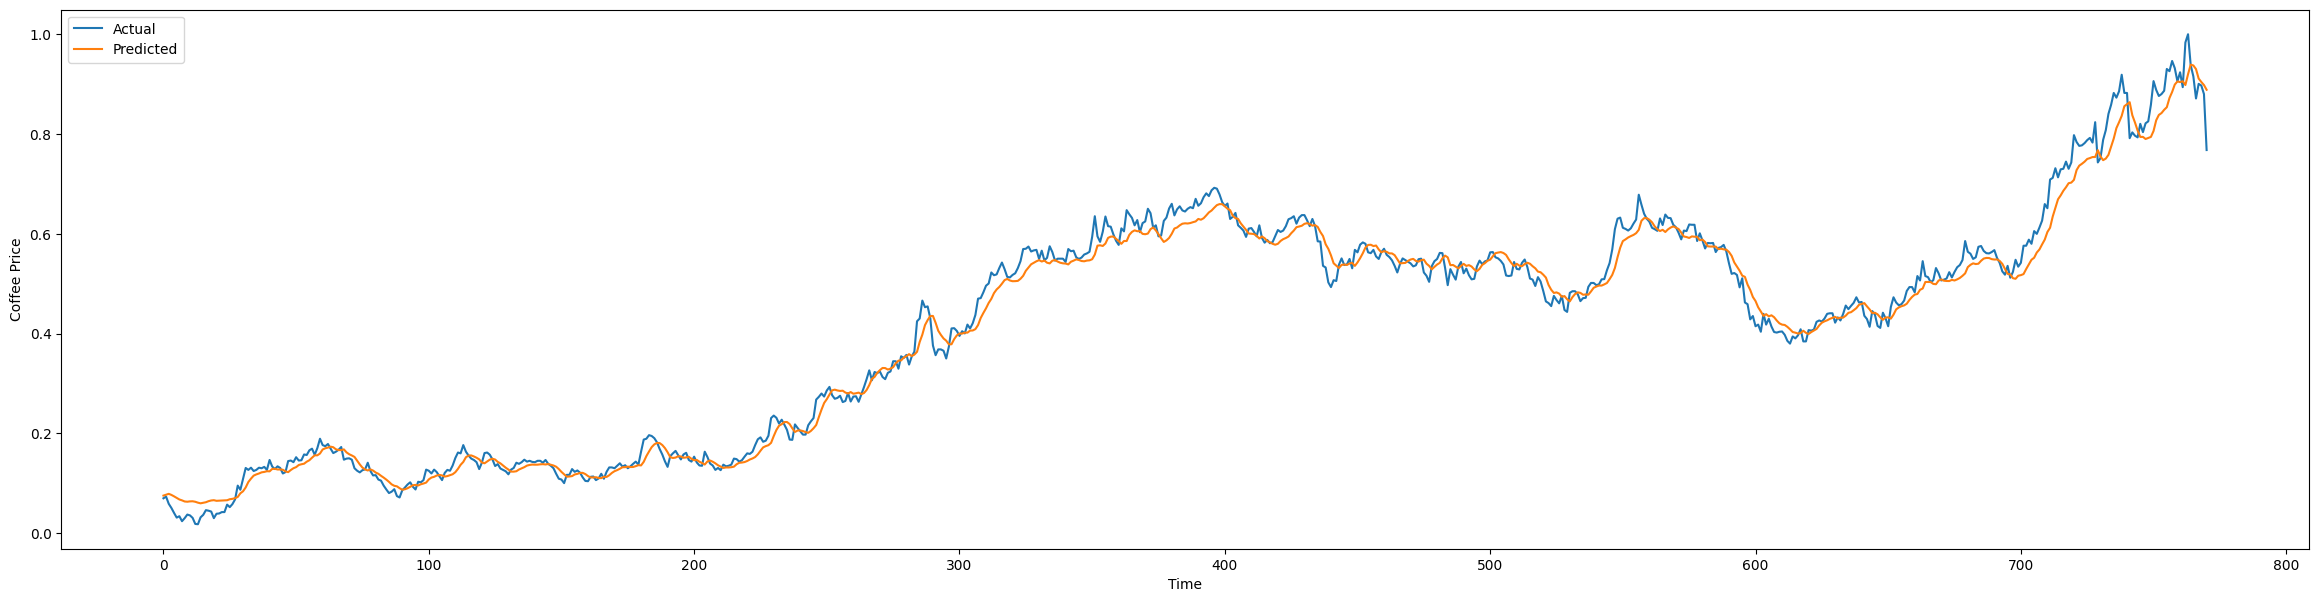

In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)
# Plot the actual and predicted prices
plt.figure(figsize=(29, 7))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Coffee Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Scale the predicted values back to the original range
y_pred_inverse = scaler.inverse_transform(np.concatenate((X_test[:, -1, 0].reshape(-1, 1), y_pred), axis=1))[:, 1]

# Scale the actual values back to the original range
y_test_inverse = scaler.inverse_transform(np.concatenate((X_test[:, -1, 0].reshape(-1, 1), y_test.reshape(-1, 1)), axis=1))[:, 1]

# Calculate MAPE and RMSE
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))

print('MAPE: {:.2f}%'.format(mape))
print('RMSE:', rmse)


MAPE: 16.34%
RMSE: 4.912739284140227


In [ ]:
# Get the last n_steps data points from the dataset
last_sequence = scaled_data[-n_steps:]

# Create an empty list to store the predicted values
predicted_values = []

# Generate the next 30 days of predictions
for _ in range(30):
    # Reshape the last_sequence to match the input shape of the model
    X_pred = np.array([last_sequence])
    X_pred = np.reshape(X_pred, (X_pred.shape[0], X_pred.shape[1], 2))

    # Predict the next value
    y_pred = model.predict(X_pred)

    # Append the predicted value to the predicted_values list
    predicted_values.append(y_pred[0][0])

    # Update the last_sequence by removing the first data point and appending the predicted value
    last_sequence = np.append(last_sequence[1:], [[y_pred[0][0], last_sequence[-1][1]]], axis=0)


# Inverse transform the predicted values to their original scale
predicted_values = scaler.inverse_transform([[val, 0] for val in predicted_values])

# Create a date range for the next 30 days
last_date = df.index[-1]
next_30_days = pd.date_range(start=last_date + pd.DateOffset(1), periods=30, freq='B')

# Create a DataFrame to store the predicted values with their corresponding dates
predictions_df = pd.DataFrame(data=predicted_values, columns=['price_coffee', 'price_oil'], index=next_30_days)

# Print the predicted coffee prices for the next 30 days
print(predictions_df['price_coffee'])
predictions_df.to_csv('predict.csv', index=False)


1/1 [==============================] - 0s 32ms/step
2023-07-07    2481.342399
2023-07-10    2470.820639
2023-07-11    2461.935121
2023-07-12    2451.494553
2023-07-13    2440.749488
2023-07-14    2429.811955
2023-07-17    2418.892969
2023-07-18    2408.075338
2023-07-19    2397.415994
2023-07-20    2386.943186
2023-07-21    2376.671580
2023-07-24    2366.604194
2023-07-25    2356.741675
2023-07-26    2347.083160
2023-07-27    2337.629297
2023-07-28    2328.373508
2023-07-31    2319.309108
2023-08-01    2310.429412
2023-08-02    2301.728490
2023-08-03    2293.200519
2023-08-04    2284.839999
2023-08-07    2276.641864
2023-08-08    2268.600937
2023-08-09    2260.712582
2023-08-10    2252.972163
2023-08-11    2245.375259
2023-08-14    2237.917664
2023-08-15    2230.595282
2023-08-16    2223.403907
2023-08-17    2216.339980
Freq: B, Name: price_coffee, dtype: float64


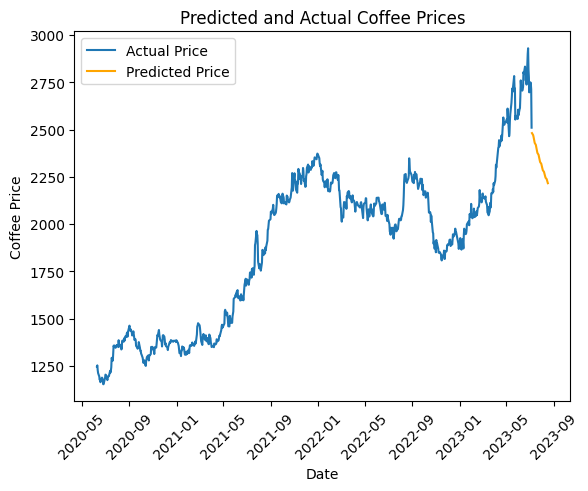

In [ ]:
# Plot the predicted and actual coffee prices
plt.plot(df.index[train_size + n_steps:], df['price_coffee'].values[train_size + n_steps:], label='Actual Price')
plt.plot(predictions_df.index, predictions_df['price_coffee'], color='orange', label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Coffee Price')
plt.title('Predicted and Actual Coffee Prices')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
import csv

data = [
    ['2023-07-07', 2462.729789],
    ['2023-07-10', 2447.587521],
    ['2023-07-11', 2431.967265],
    ['2023-07-12', 2416.894005],
    ['2023-07-13', 2402.587595],
    ['2023-07-14', 2388.99175],
    ['2023-07-17', 2376.055685],
    ['2023-07-18', 2363.736701],
    ['2023-07-19', 2351.99706],
    ['2023-07-20', 2340.803551],
    ['2023-07-21', 2330.126093],
    ['2023-07-24', 2319.936757],
    ['2023-07-25', 2310.209342],
    ['2023-07-26', 2300.920235],
    ['2023-07-27', 2291.970453],
    ['2023-07-28', 2283.142621],
    ['2023-07-31', 2274.38067],
    ['2023-08-01', 2265.678993],
    ['2023-08-02', 2257.035756],
    ['2023-08-03', 2248.449128],
    ['2023-08-04', 2239.917383],
    ['2023-08-07', 2231.439011],
    ['2023-08-08', 2223.01261],
    ['2023-08-09', 2214.636564],
    ['2023-08-10', 2206.309578],
    ['2023-08-11', 2198.029927],
    ['2023-08-14', 2189.796533],
    ['2023-08-15', 2181.607778],
    ['2023-08-16', 2173.462585],
    ['2023-08-17', 2165.359443]
]

# Specify the name of the CSV file
filename = 'data.csv'

# Write the data to the CSV file
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

print(f'{filename} has been created successfully.')


Date: 07/07/2023
Coffee Price: 2624.07
Oil Price: 70.72

Date: 08/07/2023
Coffee Price: 2624.07
Oil Price: 70.72

Date: 09/07/2023
Coffee Price: 2624.07
Oil Price: 70.72

Date: 10/07/2023
Coffee Price: 2624.07
Oil Price: 70.72

Date: 11/07/2023
Coffee Price: 2624.07
Oil Price: 70.72

Date: 12/07/2023
Coffee Price: 2624.07
Oil Price: 70.72

Date: 13/07/2023
Coffee Price: 2624.07
Oil Price: 70.72

Date: 14/07/2023
Coffee Price: 2624.07
Oil Price: 70.72

Date: 15/07/2023
Coffee Price: 2624.07
Oil Price: 70.72

Date: 16/07/2023
Coffee Price: 2624.07
Oil Price: 70.72

Date: 17/07/2023
Coffee Price: 2624.07
Oil Price: 70.72

Date: 18/07/2023
Coffee Price: 2624.07
Oil Price: 70.72

Date: 19/07/2023
Coffee Price: 2624.07
Oil Price: 70.72

Date: 20/07/2023
Coffee Price: 2624.07
Oil Price: 70.72

Date: 21/07/2023
Coffee Price: 2624.07
Oil Price: 70.72

Date: 22/07/2023
Coffee Price: 2624.07
Oil Price: 70.72

Date: 23/07/2023
Coffee Price: 2624.07
Oil Price: 70.72

Date: 24/07/2023
Coffee Price: 